# Assignment 2

In assignment 2, you will build five classification models on six different datasets. You can then compare them to see which modeling technique works best on each dataset using AUC and the scaled brier score as the metrics.
 
Learning objective: (a) how to train and evaluate models, (b) comparing modeling techniques

## Some notes

For reference, please see "Lecture 3 - Tree Examples 2023.ipynb", "Lecture 4 - Nested K-cross validation of CART on CCHS.ipynb", "Lecture 4 - Parallel nested CV on CCHS.ipynb", and "sdgm-getting started.pdf"

Five classification models available in `sdgm` are:
1. logistic regression: `lr.bestmodel.bin`
2. CART: `cart.bestmodel.bin`
3. random forest: `rf.bestmodel.bin`
4. LightGBM (lgbm): `lgbm.bestmodel.bin`
5. support vector machine (svm): `svm.bestmodel.bin`

## Load useful packages

In [73]:
library(sdgm)
library(dplyr)
library(ggplot2)

## Some preparation work

In [74]:
# Change plot size to 18 * 6
options(repr.plot.width=18, repr.plot.height=6) 

In [75]:
n_iter <- 1 #make 1 for now chnage to 20 later
train_data_split <- 0.8
model_vec <- c("lr", "cart", "rf", "lgbm", "svm") # names of models

In [76]:
# -------- define dataframes to save the intermediate results ---------
# AUC values of the repeated train/test split, 15 times
auc_split <- data.frame(type = rep("train/test split", 15),
                      metric = rep("auc", 15),
                      lr = rep(0, 15),
                      cart = rep(0, 15),
                      rf = rep(0, 15),
                      lgbm = rep(0, 15),
                      svm = rep(0, 15))

# AUC values of the repeated nested cv, 15 times
auc_cv <- data.frame(type = rep("nested cv", 15),
                      metric = rep("auc", 15),
                      lr = rep(0, 15),
                      cart = rep(0, 15),
                      rf = rep(0, 15),
                      lgbm = rep(0, 15),
                      svm = rep(0, 15))

# brier scores of the repeated train/test split, 15 times
brier_split <- data.frame(type = rep("train/test split", 15),
                        metric = rep("brier", 15),
                        lr = rep(0, 15),
                        cart = rep(0, 15),
                        rf = rep(0, 15),
                        lgbm = rep(0, 15),
                        svm = rep(0, 15))

# brier scores of the repeated nested cv, 15 times
brier_cv <- data.frame(type = rep("nested cv", 15),
                        metric = rep("brier", 15),
                        lr = rep(0, 15),
                        cart = rep(0, 15),
                        rf = rep(0, 15),
                        lgbm = rep(0, 15),
                        svm = rep(0, 15))

## Dataset 1: `sdgm::C2` BankNote

For more details about this dataset, see [here](https://archive.ics.uci.edu/dataset/267/banknote+authentication)

In [17]:
# show the description of this dataset
?sdgm::C2

C2 {sdgm},R Documentation


In [18]:
# first glance of the dataset
full_data <- sdgm::C2
head(full_data)
dim(full_data)

,var,skew,curtosis,entropy,class
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,4.54590,8.1674,-2.45860,-1.46210,'0'
2,3.86600,-2.6383,1.92420,0.10645,'0'
3,3.45660,9.5228,-4.01120,-3.59440,'0'
4,0.32924,-4.4552,4.57180,-0.98880,'0'
5,4.36840,9.6718,-3.96060,-3.16250,'0'
6,3.59120,3.0129,0.72888,0.56421,'0'


[1] 1371    5

In [19]:
# Convert characters to numbers. Note because of the special format in the data, `as.numeric` doesn't work here.
# The code below is to extract numbers from strings
full_data$class <- as.numeric(gsub("\\D", "", full_data$class))

In [20]:
# Check the data now
summary(full_data)
head(full_data)

# Check the outcome variable
table(full_data$class)

      var               skew            curtosis          entropy       
 Min.   :-7.0421   Min.   :-13.773   Min.   :-5.2861   Min.   :-8.5482  
 1st Qu.:-1.7747   1st Qu.: -1.711   1st Qu.:-1.5534   1st Qu.:-2.4170  
 Median : 0.4957   Median :  2.313   Median : 0.6166   Median :-0.5867  
 Mean   : 0.4314   Mean   :  1.917   Mean   : 1.4007   Mean   :-1.1922  
 3rd Qu.: 2.8146   3rd Qu.:  6.813   3rd Qu.: 3.1816   3rd Qu.: 0.3948  
 Max.   : 6.8248   Max.   : 12.952   Max.   :17.9274   Max.   : 2.4495  
     class       
 Min.   :0.0000  
 1st Qu.:0.0000  
 Median :0.0000  
 Mean   :0.4449  
 3rd Qu.:1.0000  
 Max.   :1.0000  

,var,skew,curtosis,entropy,class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,4.54590,8.1674,-2.45860,-1.46210,0
2,3.86600,-2.6383,1.92420,0.10645,0
3,3.45660,9.5228,-4.01120,-3.59440,0
4,0.32924,-4.4552,4.57180,-0.98880,0
5,4.36840,9.6718,-3.96060,-3.16250,0
6,3.59120,3.0129,0.72888,0.56421,0



  0   1 
761 610 

### Question 1.1: Based on what you have learnt about the dataset, is there anything should be done to prepare the data?

**Hint 1:** Are all the variables in the correct variable type?

**Hint 2 (Important!):** As per some models' requirement, the outcome variable has to be a numeric variable between 0 and 1.

***Note:*** Some datasets need a bit of data preparation and some don't. If you think this one needs to be prepared, choose "yes" and add your code in the below cell. Otherwise, choose "no" and leave the below cell unchanged.

Your answer: no

In [21]:
# The data preparation step if needed

# Check the data now
summary(full_data)

      var               skew            curtosis          entropy       
 Min.   :-7.0421   Min.   :-13.773   Min.   :-5.2861   Min.   :-8.5482  
 1st Qu.:-1.7747   1st Qu.: -1.711   1st Qu.:-1.5534   1st Qu.:-2.4170  
 Median : 0.4957   Median :  2.313   Median : 0.6166   Median :-0.5867  
 Mean   : 0.4314   Mean   :  1.917   Mean   : 1.4007   Mean   :-1.1922  
 3rd Qu.: 2.8146   3rd Qu.:  6.813   3rd Qu.: 3.1816   3rd Qu.: 0.3948  
 Max.   : 6.8248   Max.   : 12.952   Max.   :17.9274   Max.   : 2.4495  
     class       
 Min.   :0.0000  
 1st Qu.:0.0000  
 Median :0.0000  
 Mean   :0.4449  
 3rd Qu.:1.0000  
 Max.   :1.0000  

In [22]:
# remove one variable to add more variance to the the outputs across the repeated evaluations
full_data <- full_data %>% select(-var)

### Question 1.2: Build five different models and evaluate them

In [35]:
# define the outcome variable
voutcome <- "class"

Note: You will use parallel computing here, see "Lecture 4 - Parallel nested CV on CCHS.ipynb".

Hint: remember to include "model" in the vector when you call `parallel::clusterExport`. For more details about `parallel::clusterExport`, see [here](https://cran.r-project.org/web/packages/SimDesign/vignettes/Fixed_obj_fun.html).

In [36]:
# ============= 15 repeated train/test split ============= 
for (model in model_vec) {
    
    # parallel computing
    cl<-parallel::makeCluster(5)
    parallel::clusterExport(cl, c("full_data", "voutcome", "model"), envir = environment() )
    
    res <- parallel::parSapply(cl, 1:15, function(x)
    {
        # partition data into train and test portions
        idx <- splitTools::partition(rep(0,nrow(full_data)), p=c(train=0.7, test=0.3), type="stratified")
        
        # retrieve train and test data
        train_data <- full_data[idx$train,]
        test_data <- full_data[idx$test,]
        
        # build the model
        if (model == "lr") {
            best_model<-sdgm::lr.bestmodel.bin(train_data, voutcome)
        } else if (model == "cart") {
            best_model<-sdgm::cart.bestmodel.bin(train_data, voutcome)
        } else if (model == "rf") {
            best_model<-sdgm::cart.bestmodel.bin(train_data, voutcome)
        } else if (model == "lgbm") {
            best_model<-sdgm::cart.bestmodel.bin(train_data, voutcome)
        } else if (model == "svm") {
            best_model<-sdgm::cart.bestmodel.bin(train_data, voutcome)
        }
        
        # predict
        preds<-predict(best_model, test_data)
  
        # calculate and return AUC and brier score
         if (!is.null(preds))
        {
          test_auc <- sdgm::auc(preds, test_data[,voutcome] ) 
        } else {
          test_auc <- NA
          print("AUC calculation failed because there are no predicted values")
        }
        print(paste0("AUC on C2 Data: ", test_auc))
        
         if (!is.null(preds))
        {
          test_brier <- sdgm::brier(preds, test_data[,voutcome] ) 
        } else {
          test_brier <- NA
          print("Brier calculation failed because there are no predicted values")
        }
          print(paste0("Brier Score on C2 Data: ", test_brier))

        c(test_auc, test_brier)
    })
    parallel::stopCluster(cl)
    
    # save results of the model
    if (model == "lr") {
        auc_split$lr <- res[1,]
        brier_split$lr <- res[2,]
    } else if (model == "cart") {
        auc_split$cart <- res[1,]
        brier_split$cart <- res[2,]
    } else if (model == "rf") {
        auc_split$rf <- res[1,]
        brier_split$rf <- res[2,]
    } else if (model == "lgbm") {
        auc_split$lgbm <- res[1,]
        brier_split$lgbm <- res[2,]
    } else if (model == "svm") {
        auc_split$svm <- res[1,]
        brier_split$svm <- res[2,]
    }
}

# save results
res.split.df1 <- rbind(auc_split, brier_split)

# print results
print(res.split.df1)

               type metric        lr      cart        rf      lgbm       svm
1  train/test split    auc 0.8810511 0.9428629 0.9421228 0.9376019 0.9328308
2  train/test split    auc 0.8798070 0.8989413 0.9345813 0.9293939 0.9439680
3  train/test split    auc 0.8964706 0.9238433 0.9366793 0.9518103 0.9361905
4  train/test split    auc 0.8983369 0.9372078 0.9457635 0.9457623 0.9576960
5  train/test split    auc 0.8694490 0.9189619 0.9378411 0.9468870 0.9385047
6  train/test split    auc 0.8789462 0.9245359 0.9380287 0.9362527 0.9470427
7  train/test split    auc 0.9007870 0.9313208 0.9084395 0.9408384 0.9187877
8  train/test split    auc 0.8797203 0.9013394 0.9184202 0.9094213 0.9280604
9  train/test split    auc 0.8474086 0.9251433 0.8899548 0.9269965 0.9352887
10 train/test split    auc 0.8729312 0.9495342 0.9322372 0.9252374 0.9361338
11 train/test split    auc 0.8888014 0.9377319 0.8904481 0.9466676 0.9106812
12 train/test split    auc 0.8903842 0.9295259 0.9285952 0.9335701 0.9310020

Mimic the structure in the last cell, complete the below cell for nested CV. Remember to use parallel computing.

In [38]:
# ============= repeated nested 5-fold CV ============= 
for (model in model_vec) {
    # parallel computing
    cl <- parallel::makeCluster(5)
    parallel::clusterExport(cl, c("full_data", "voutcome", "model"), envir = environment())
    
    # this is the repeated loop
    res <- parallel::parSapply(cl, seq(15), function(i) 
    {
        # this is the nested CV outer loop
        nested_res <- sapply(caret::createFolds(full_data[, voutcome], k=5), function(x) 
        {
            testInds <- x
            trnInds <- setdiff(1:nrow(full_data), testInds)
            train_data <- full_data[trnInds,]
            test_data <- full_data[testInds,]

            if (model == "lr") {
                best_model <- sdgm::lr.bestmodel.bin(train_data, voutcome)
            } else if (model == "cart") {
                best_model <- sdgm::cart.bestmodel.bin(train_data, voutcome)
            } else if (model == "rf") {
                best_model <- sdgm::rf.bestmodel.bin(train_data, voutcome)
            } else if (model == "lgbm") {
                best_model <- sdgm::lgbm.bestmodel.bin(train_data, voutcome)
            } else if (model == "svm") {
                best_model <- sdgm::svm.bestmodel.bin(train_data, voutcome)
            }
            
            #predict
            preds <- predict(best_model, test_data)
            
            # calculate and return AUC and brier score
             if (!is.null(preds)) {
                nested_auc <- sdgm::auc(preds, test_data[, voutcome])
                nested_brier <- sdgm::brier(preds, test_data[, voutcome])
            } else {
                nested_auc <- NA
                nested_brier <- NA
            }

            c(nested_auc, nested_brier)
        })
        nested_cv_auc <- mean(nested_res[1,], na.rm=T)
        nested_cv_brier <- mean(nested_res[2,], na.rm=T)
                               
        c(nested_cv_auc, nested_cv_brier)
    })
    parallel::stopCluster(cl)
    
    # save results of the model
    if (model == "lr") {
        auc_cv$lr <- res[1,]
        brier_cv$lr <- res[2,]
    } else if (model == "cart") {
        auc_cv$cart <- res[1,]
        brier_cv$cart <- res[2,]
    } else if (model == "rf") {
        auc_cv$rf <- res[1,]
        brier_cv$rf <- res[2,]
    } else if (model == "lgbm") {
        auc_cv$lgbm <- res[1,]
        brier_cv$lgbm <- res[2,]
    } else if (model == "svm") {
        auc_cv$svm <- res[1,]
        brier_cv$svm <- res[2,]
    }
}

# save results
res.cv.df1 <- rbind(auc_cv, brier_cv)

print(res.cv.df1)

        type metric        lr      cart        rf      lgbm       svm
1  nested cv    auc 0.8800712 0.9360542 0.9766600 0.9930619 0.9889192
2  nested cv    auc 0.8818544 0.9328486 0.9775309 0.9915695 0.9890308
3  nested cv    auc 0.8806780 0.9364220 0.9773769 0.9914718 0.9889616
4  nested cv    auc 0.8799912 0.9399572 0.9759649 0.9914885 0.9867965
5  nested cv    auc 0.8808917 0.9342340 0.9773220 0.9899350 0.9882087
6  nested cv    auc 0.8808848 0.9232185 0.9768224 0.9916523 0.9872321
7  nested cv    auc 0.8805400 0.9246875 0.9775947 0.9920397 0.9894846
8  nested cv    auc 0.8808567 0.9221357 0.9778776 0.9893818 0.9892102
9  nested cv    auc 0.8800007 0.9257776 0.9751887 0.9911431 0.9855101
10 nested cv    auc 0.8812678 0.9397477 0.9759442 0.9908715 0.9877028
11 nested cv    auc 0.8810900 0.9374839 0.9770093 0.9914696 0.9866977
12 nested cv    auc 0.8801596 0.9341720 0.9761474 0.9928005 0.9889067
13 nested cv    auc 0.8806364 0.9403692 0.9788164 0.9908050 0.9867071
14 nested cv    auc 

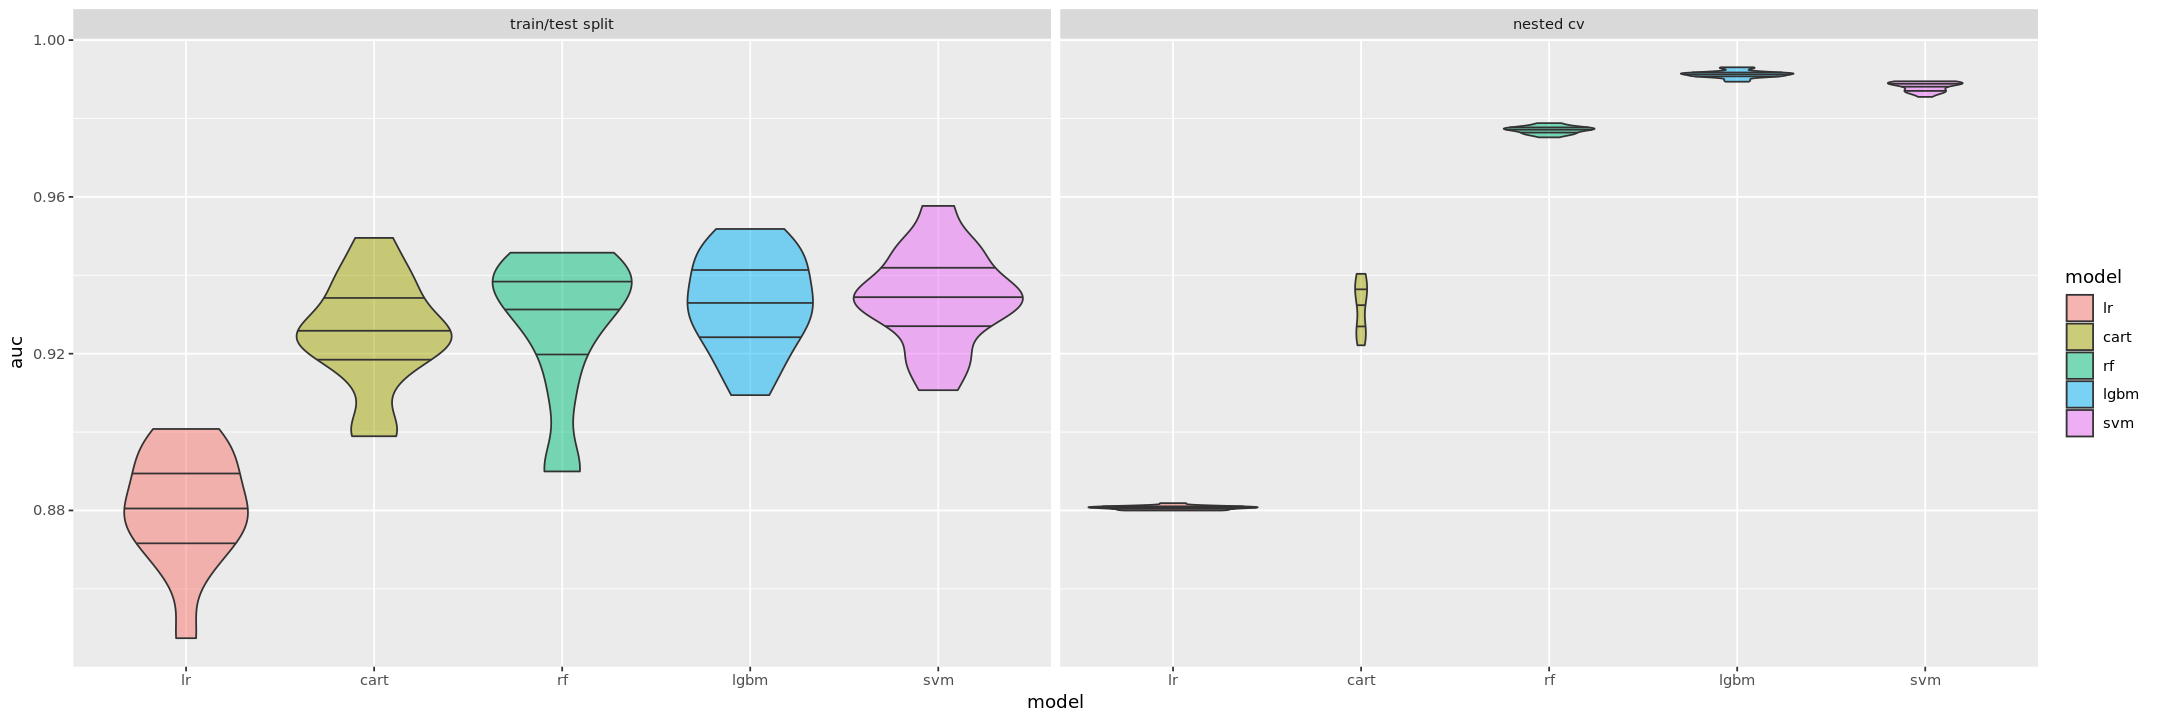

In [39]:
auc.df1 <- rbind(res.split.df1 %>% filter(metric == "auc"), 
                 res.cv.df1 %>% filter(metric == "auc"))

# pivot the dataframe from wide to long for plotting
auc.df1.long <- auc.df1 %>% 
    tidyr::pivot_longer(-c(type, metric), 
                        names_to = "model",
                        values_to = "auc")
auc.df1.long$model <- factor(auc.df1.long$model, 
                         levels = c("lr", "cart", "rf", "lgbm", "svm"))
auc.df1.long$type <- factor(auc.df1.long$type, 
                         levels = c("train/test split", "nested cv"))

# Plot the violin plot
ggplot(auc.df1.long, aes(model, auc, fill = model)) + 
    geom_violin(alpha = 0.5, draw_quantiles = c(0.25, 0.5, 0.75))+ 
    facet_wrap(~type)

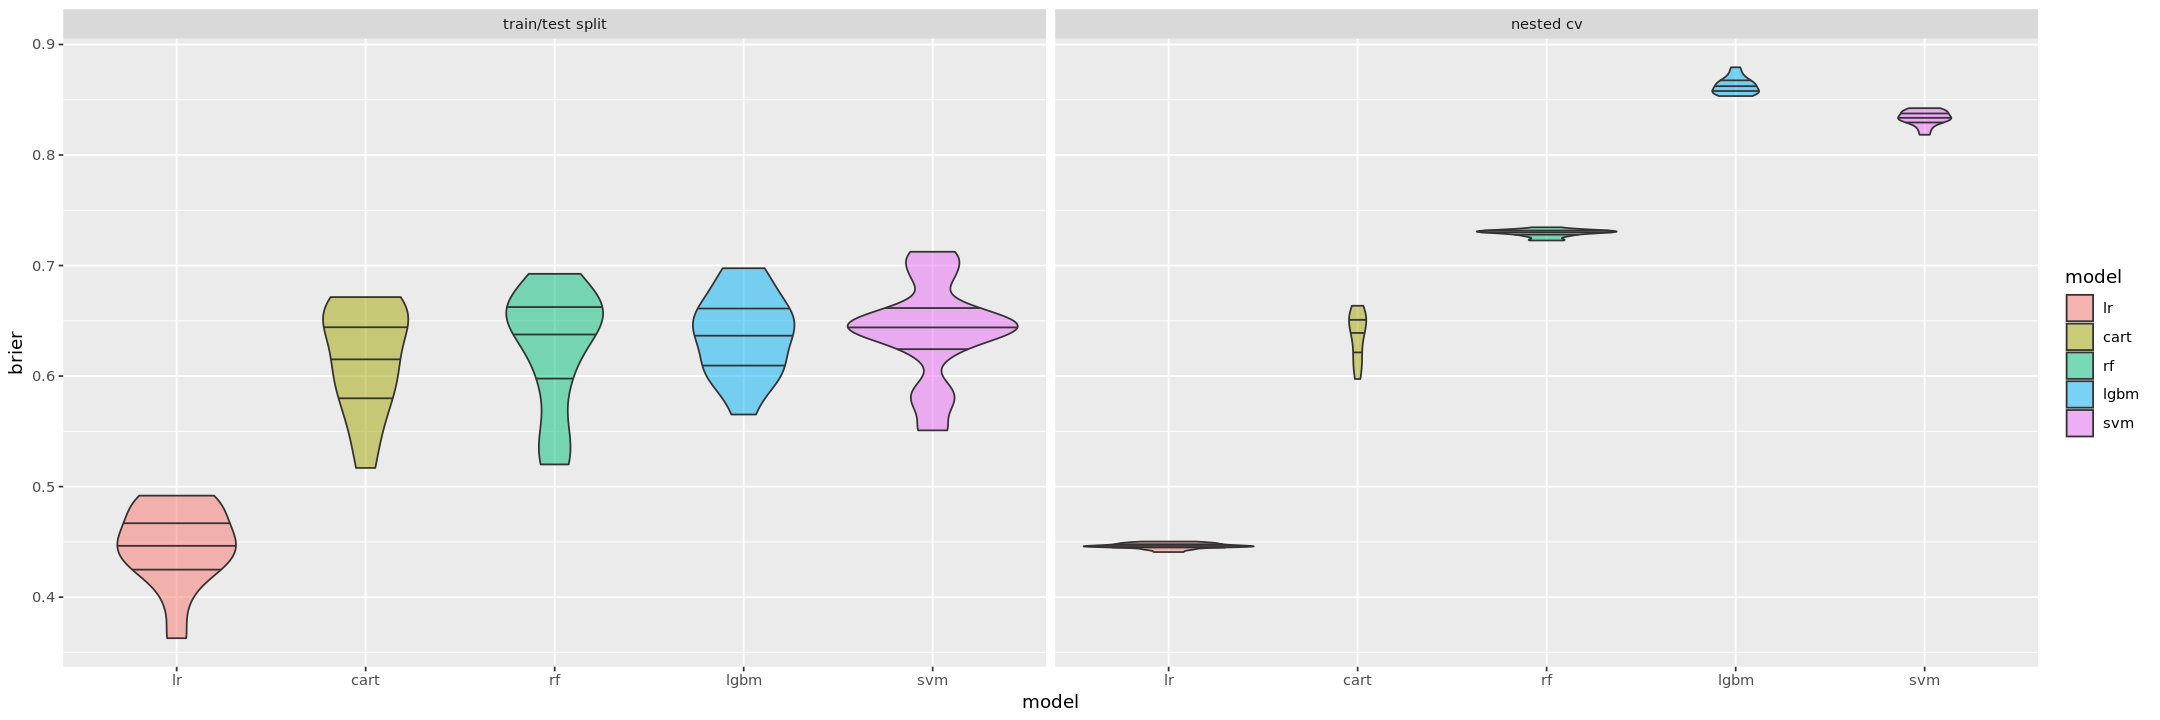

In [40]:
brier.df1 <- rbind(res.split.df1 %>% filter(metric == "brier"), 
                   res.cv.df1 %>% filter(metric == "brier"))

# pivot the dataframe from wide to long for plotting
brier.df1.long <- brier.df1 %>% 
    tidyr::pivot_longer(-c(type,metric), 
                        names_to = "model",
                        values_to = "brier")
brier.df1.long$model <- factor(brier.df1.long$model, 
                         levels = c("lr", "cart", "rf", "lgbm", "svm"))
brier.df1.long$type <- factor(brier.df1.long$type, 
                         levels = c("train/test split", "nested cv"))

# Plot the violin plot
ggplot(brier.df1.long, aes(model, brier, fill = model)) + 
    geom_violin(alpha = 0.5, draw_quantiles = c(0.25, 0.5, 0.75))+ 
    facet_wrap(~type)

### Question 1.3: Based on the above violin plot, which model is the best one? Why?

## Dataset 2: `sdgm::C3` Breast Cancer Wisconsin

For more details about this dataset, see [here](https://archive.ics.uci.edu/dataset/15/breast+cancer+wisconsin+original)

In [77]:
# show the description of this dataset
?sdgm::C3

C3 {sdgm},R Documentation


In [78]:
# first glance of the dataset
full_data <- sdgm::C3
head(full_data)
dim(full_data)

,ClumpThickness,UniformityCellSize,UniformityCellShape,MarginalAdhesion,SingleEpithelialCellSize,BareNuclei,BlandChromatin,NormalNucleoli,Mitosis,Class
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
1,5,1,1,1,2,1,3,1,1,'2'
2,5,4,4,5,7,10,3,2,1,'2'
3,3,1,1,1,2,2,3,1,1,'2'
4,6,8,8,1,3,4,3,7,1,'2'
5,4,1,1,3,2,1,3,1,1,'2'
6,8,10,10,8,7,10,9,7,1,'4'


[1] 683  10

In [79]:
# Convert characters to numbers. Note because of the special format in the data, `as.numeric` doesn't work here.
# The code below is to extract numbers from strings
full_data$Class <- as.numeric(gsub("\\D", "", full_data$Class))

In [80]:
# Check the data now
summary(full_data)

# Check the outcome variable
table(full_data$Class)

 ClumpThickness   UniformityCellSize UniformityCellShape MarginalAdhesion
 Min.   : 1.000   Min.   : 1.000     Min.   : 1.000      Min.   : 1.00   
 1st Qu.: 2.000   1st Qu.: 1.000     1st Qu.: 1.000      1st Qu.: 1.00   
 Median : 4.000   Median : 1.000     Median : 1.000      Median : 1.00   
 Mean   : 4.442   Mean   : 3.151     Mean   : 3.215      Mean   : 2.83   
 3rd Qu.: 6.000   3rd Qu.: 5.000     3rd Qu.: 5.000      3rd Qu.: 4.00   
 Max.   :10.000   Max.   :10.000     Max.   :10.000      Max.   :10.00   
 SingleEpithelialCellSize   BareNuclei     BlandChromatin   NormalNucleoli 
 Min.   : 1.000           Min.   : 1.000   Min.   : 1.000   Min.   : 1.00  
 1st Qu.: 2.000           1st Qu.: 1.000   1st Qu.: 2.000   1st Qu.: 1.00  
 Median : 2.000           Median : 1.000   Median : 3.000   Median : 1.00  
 Mean   : 3.234           Mean   : 3.545   Mean   : 3.445   Mean   : 2.87  
 3rd Qu.: 4.000           3rd Qu.: 6.000   3rd Qu.: 5.000   3rd Qu.: 4.00  
 Max.   :10.000           


  2   4 
444 239 

### Question 2.1: Based on what you have learnt about the dataset, is there anything should be done to prepare the data?

**Hint 1:** Are all the variables in the correct variable type?

**Hint 2 (Important!):** As per some models' requirement, the outcome variable has to be a numeric variable between 0 and 1.

***Note:*** Some datasets need a bit of data preparation and some don't. If you think this one needs to be prepared, choose "yes" and add your code in the below cell. Otherwise, choose "no" and leave the below cell unchanged.

Your answer: yes

In [81]:
# The data preparation step if needed
full_data$Class <- ifelse(full_data$Class == 2, 0, ifelse(full_data$Class == 4, 1, full_data$Class))
table(full_data$Class)

# Check the data now
summary(full_data)


  0   1 
444 239 

 ClumpThickness   UniformityCellSize UniformityCellShape MarginalAdhesion
 Min.   : 1.000   Min.   : 1.000     Min.   : 1.000      Min.   : 1.00   
 1st Qu.: 2.000   1st Qu.: 1.000     1st Qu.: 1.000      1st Qu.: 1.00   
 Median : 4.000   Median : 1.000     Median : 1.000      Median : 1.00   
 Mean   : 4.442   Mean   : 3.151     Mean   : 3.215      Mean   : 2.83   
 3rd Qu.: 6.000   3rd Qu.: 5.000     3rd Qu.: 5.000      3rd Qu.: 4.00   
 Max.   :10.000   Max.   :10.000     Max.   :10.000      Max.   :10.00   
 SingleEpithelialCellSize   BareNuclei     BlandChromatin   NormalNucleoli 
 Min.   : 1.000           Min.   : 1.000   Min.   : 1.000   Min.   : 1.00  
 1st Qu.: 2.000           1st Qu.: 1.000   1st Qu.: 2.000   1st Qu.: 1.00  
 Median : 2.000           Median : 1.000   Median : 3.000   Median : 1.00  
 Mean   : 3.234           Mean   : 3.545   Mean   : 3.445   Mean   : 2.87  
 3rd Qu.: 4.000           3rd Qu.: 6.000   3rd Qu.: 5.000   3rd Qu.: 4.00  
 Max.   :10.000           

### Question 2.2: Build five different models and evaluate them

In [83]:
# define the outcome variable
voutcome <- "Class"

Based on what you have done for Dataset 1, complete the below cells of this dataset. Remember to use parallel computing.

In [84]:
# ============= 15 repeated train/test split ============= 
for (model in model_vec) {
    
    # parallel computing
    cl<-parallel::makeCluster(5)
    parallel::clusterExport(cl, c("full_data", "voutcome", "model"), envir = environment() )
    
    res <- parallel::parSapply(cl, 1:15, function(x)
    {
        # partition data into train and test portions
        idx <- splitTools::partition(rep(0,nrow(full_data)), p=c(train=0.7, test=0.3), type="stratified")
        
        # retrieve train and test data
        train_data <- full_data[idx$train,]
        test_data <- full_data[idx$test,]
        
        # build the model
        if (model == "lr") {
            best_model<-sdgm::lr.bestmodel.bin(train_data, voutcome)
        } else if (model == "cart") {
            best_model<-sdgm::cart.bestmodel.bin(train_data, voutcome)
        } else if (model == "rf") {
            best_model<-sdgm::cart.bestmodel.bin(train_data, voutcome)
        } else if (model == "lgbm") {
            best_model<-sdgm::cart.bestmodel.bin(train_data, voutcome)
        } else if (model == "svm") {
            best_model<-sdgm::cart.bestmodel.bin(train_data, voutcome)
        }
        
        # predict
        preds<-predict(best_model, test_data)
  
        # calculate and return AUC and brier score
         if (!is.null(preds))
        {
          test_auc <- sdgm::auc(preds, test_data[,voutcome] ) 
        } else {
          test_auc <- NA
          print("AUC calculation failed because there are no predicted values")
        }
        print(paste0("AUC on C3 Data: ", test_auc))
        
         if (!is.null(preds))
        {
          test_brier <- sdgm::brier(preds, test_data[,voutcome] ) 
        } else {
          test_brier <- NA
          print("Brier calculation failed because there are no predicted values")
        }
          print(paste0("Brier Score on C3 Data: ", test_brier))

        c(test_auc, test_brier)
    })
    parallel::stopCluster(cl)
    
    # save results of the model
    if (model == "lr") {
        auc_split$lr <- res[1,]
        brier_split$lr <- res[2,]
    } else if (model == "cart") {
        auc_split$cart <- res[1,]
        brier_split$cart <- res[2,]
    } else if (model == "rf") {
        auc_split$rf <- res[1,]
        brier_split$rf <- res[2,]
    } else if (model == "lgbm") {
        auc_split$lgbm <- res[1,]
        brier_split$lgbm <- res[2,]
    } else if (model == "svm") {
        auc_split$svm <- res[1,]
        brier_split$svm <- res[2,]
    }
}

# save results
res.split.df2 <- rbind(auc_split, brier_split)

# print results
print(res.split.df2)  

               type metric        lr      cart        rf      lgbm       svm
1  train/test split    auc 0.9651852 0.9223379 0.9308724 0.9295879 0.9561538
2  train/test split    auc 0.9485095 0.9229210 0.9497703 0.9288856 0.9474820
3  train/test split    auc 0.9293421 0.9479104 0.9558748 0.9420970 0.9370791
4  train/test split    auc 0.9326641 0.9458496 0.9372808 0.9584589 0.9648437
5  train/test split    auc 0.9573483 0.9708574 0.9409983 0.9176941 0.9582429
6  train/test split    auc 0.9484656 0.9289066 0.9444735 0.9317484 0.9444084
7  train/test split    auc 0.9384656 0.9226374 0.9397089 0.9351371 0.9447090
8  train/test split    auc 0.9565264 0.9422564 0.9346413 0.9362828 0.9249735
9  train/test split    auc 0.9676663 0.9364344 0.9574388 0.9508379 0.9476546
10 train/test split    auc 0.9542119 0.9465128 0.9470375 0.9284213 0.9401408
11 train/test split    auc 0.9379058 0.9506763 0.9270359 0.9458281 0.9548144
12 train/test split    auc 0.9221839 0.9252381 0.9416713 0.9409983 0.9394714

In [85]:
# ============= repeated nested 5-fold CV ============= 
for (model in model_vec) {
    # parallel computing
    cl <- parallel::makeCluster(5)
    parallel::clusterExport(cl, c("full_data", "voutcome", "model"), envir = environment())
    
    # this is the repeated loop
    res <- parallel::parSapply(cl, seq(15), function(i) 
    {
        # this is the nested CV outer loop
        nested_res <- sapply(caret::createFolds(full_data[, voutcome], k=5), function(x) 
        {
            testInds <- x
            trnInds <- setdiff(1:nrow(full_data), testInds)
            train_data <- full_data[trnInds,]
            test_data <- full_data[testInds,]

            if (model == "lr") {
                best_model <- sdgm::lr.bestmodel.bin(train_data, voutcome)
            } else if (model == "cart") {
                best_model <- sdgm::cart.bestmodel.bin(train_data, voutcome)
            } else if (model == "rf") {
                best_model <- sdgm::rf.bestmodel.bin(train_data, voutcome)
            } else if (model == "lgbm") {
                best_model <- sdgm::lgbm.bestmodel.bin(train_data, voutcome)
            } else if (model == "svm") {
                best_model <- sdgm::svm.bestmodel.bin(train_data, voutcome)
            }
            
            #predict
            preds <- predict(best_model, test_data)
            
            # calculate and return AUC and brier score
             if (!is.null(preds)) {
                nested_auc <- sdgm::auc(preds, test_data[, voutcome])
                nested_brier <- sdgm::brier(preds, test_data[, voutcome])
            } else {
                nested_auc <- NA
                nested_brier <- NA
            }

            c(nested_auc, nested_brier)
        })
        nested_cv_auc <- mean(nested_res[1,], na.rm=T)
        nested_cv_brier <- mean(nested_res[2,], na.rm=T)
                               
        c(nested_cv_auc, nested_cv_brier)
    })
    parallel::stopCluster(cl)
    
    # save results of the model
    if (model == "lr") {
        auc_cv$lr <- res[1,]
        brier_cv$lr <- res[2,]
    } else if (model == "cart") {
        auc_cv$cart <- res[1,]
        brier_cv$cart <- res[2,]
    } else if (model == "rf") {
        auc_cv$rf <- res[1,]
        brier_cv$rf <- res[2,]
    } else if (model == "lgbm") {
        auc_cv$lgbm <- res[1,]
        brier_cv$lgbm <- res[2,]
    } else if (model == "svm") {
        auc_cv$svm <- res[1,]
        brier_cv$svm <- res[2,]
    }
}

# save results
res.cv.df2 <- rbind(auc_cv, brier_cv)

print(res.cv.df2)

        type metric        lr      cart        rf      lgbm       svm
1  nested cv    auc 0.9512892 0.9494182 0.9921359 0.9924689 0.9937693
2  nested cv    auc 0.9364560 0.9509556 0.9920406 0.9915584 0.9948747
3  nested cv    auc 0.9515091 0.9498723 0.9918145 0.9899491 0.9941742
4  nested cv    auc 0.9459142 0.9524355 0.9921213 0.9916444 0.9946987
5  nested cv    auc 0.9478185 0.9557283 0.9923839 0.9916571 0.9942805
6  nested cv    auc 0.9388701 0.9423536 0.9924785 0.9906304 0.9943931
7  nested cv    auc 0.9421833 0.9406718 0.9912108 0.9926505 0.9955541
8  nested cv    auc 0.9505085 0.9438981 0.9923559 0.9922441 0.9946319
9  nested cv    auc 0.9625195 0.9439238 0.9913406 0.9921508 0.9925515
10 nested cv    auc 0.9364892 0.9584787 0.9921067 0.9930894 0.9952923
11 nested cv    auc 0.9395923 0.9465222 0.9923806 0.9898561 0.9935616
12 nested cv    auc 0.9431632 0.9426370 0.9918170 0.9905256 0.9915238
13 nested cv    auc 0.9480531 0.9546212 0.9931520 0.9924527 0.9942179
14 nested cv    auc 

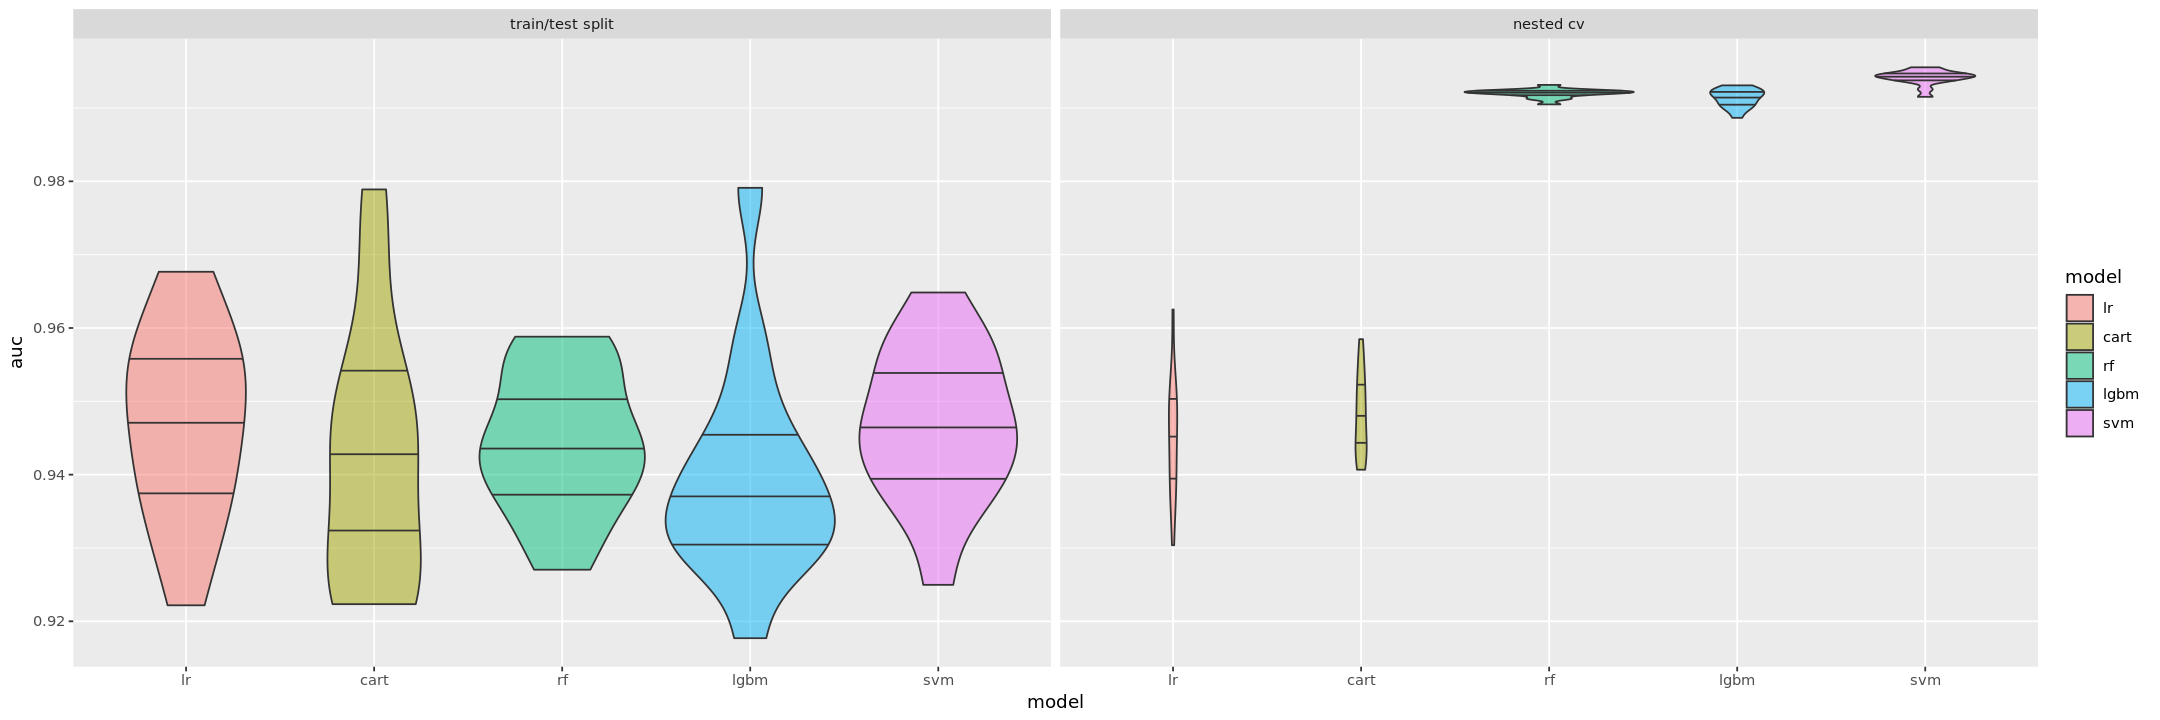

In [86]:
auc.df2 <- rbind(res.split.df2 %>% filter(metric == "auc"), 
                 res.cv.df2 %>% filter(metric == "auc"))

# pivot the dataframe from wide to long for plotting
auc.df2.long <- auc.df2 %>% 
    tidyr::pivot_longer(-c(type, metric), 
                        names_to = "model",
                        values_to = "auc")
auc.df2.long$model <- factor(auc.df2.long$model, 
                         levels = c("lr", "cart", "rf", "lgbm", "svm"))
auc.df2.long$type <- factor(auc.df2.long$type, 
                         levels = c("train/test split", "nested cv"))

# Plot the violin plot
ggplot(auc.df2.long, aes(model, auc, fill = model)) + 
    geom_violin(alpha = 0.5, draw_quantiles = c(0.25, 0.5, 0.75))+ 
    facet_wrap(~type)

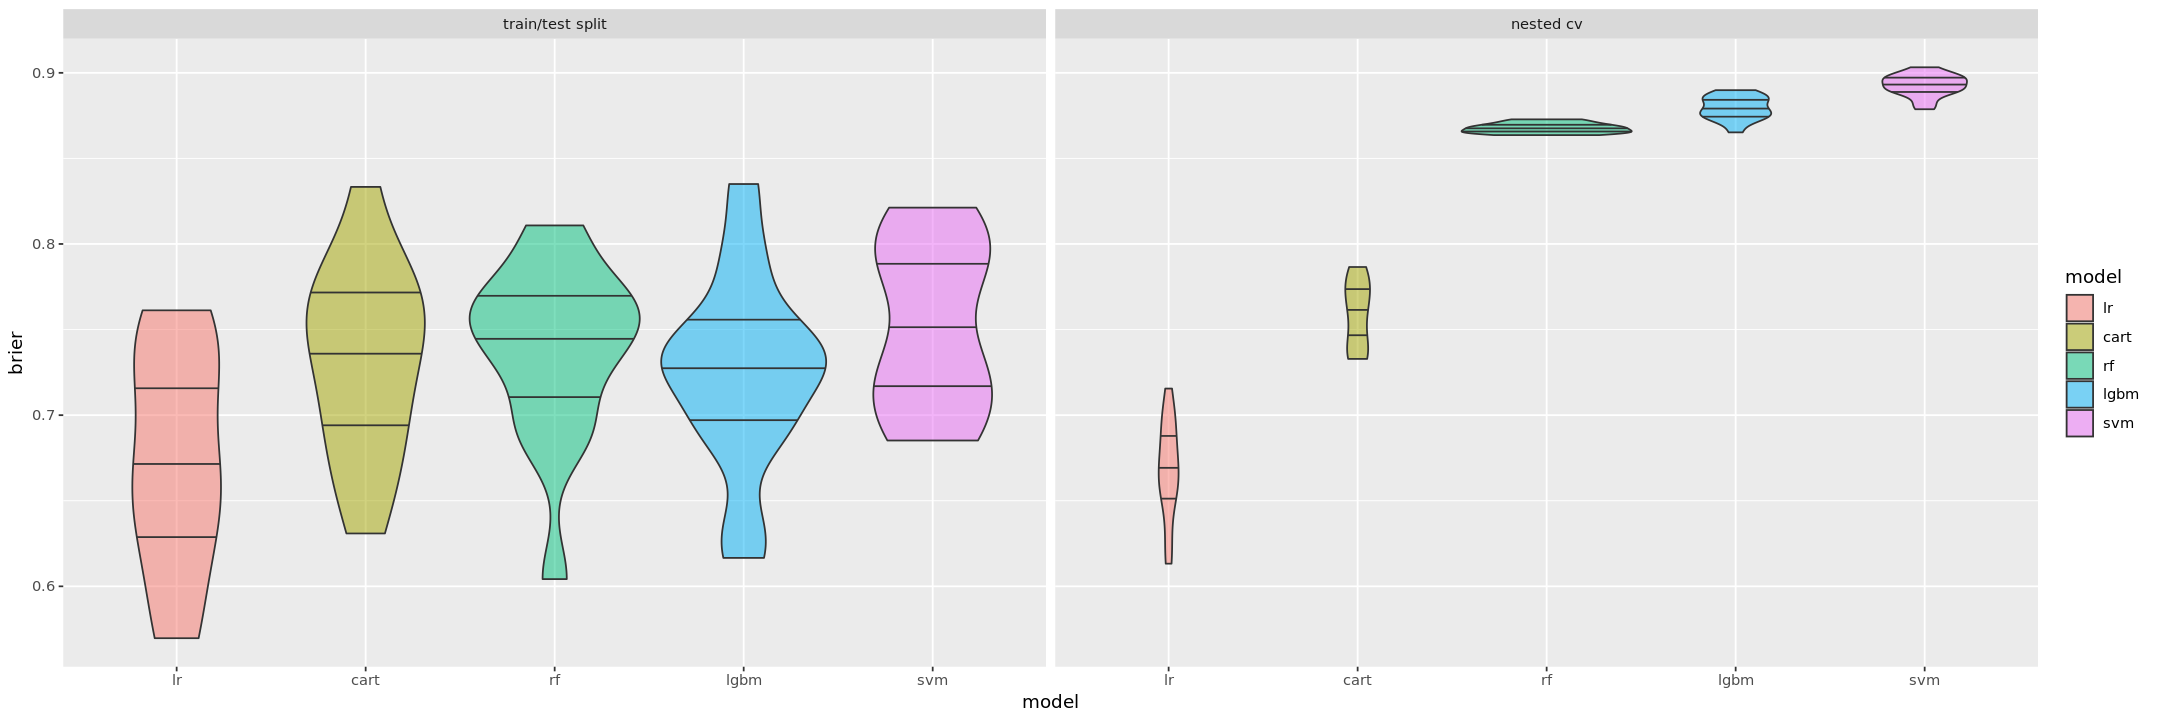

In [87]:
brier.df2 <- rbind(res.split.df2 %>% filter(metric == "brier"), 
                   res.cv.df2 %>% filter(metric == "brier"))

# pivot the dataframe from wide to long for plotting
brier.df2.long <- brier.df2 %>% 
    tidyr::pivot_longer(-c(type,metric), 
                        names_to = "model",
                        values_to = "brier")
brier.df2.long$model <- factor(brier.df2.long$model, 
                         levels = c("lr", "cart", "rf", "lgbm", "svm"))
brier.df2.long$type <- factor(brier.df2.long$type, 
                         levels = c("train/test split", "nested cv"))

# Plot the violin plot
ggplot(brier.df2.long, aes(model, brier, fill = model)) + 
    geom_violin(alpha = 0.5, draw_quantiles = c(0.25, 0.5, 0.75))+ 
    facet_wrap(~type)

### Question 2.3: Based on the above violin plot, which model is the best one? Why?

## Dataset 3: `sdgm::C16` Diabetic Retinopathy

For more details about this dataset, see [here](https://archive.ics.uci.edu/dataset/329/diabetic+retinopathy+debrecen)

In [88]:
# show the description of this dataset
?sdgm::C16

C16 {sdgm},R Documentation


In [90]:
# first glance of the dataset
full_data <- sdgm::C16
head(full_data)
dim(full_data)

,Quality,PreScreen,MA1,MA2,MA3,MA4,MA5,MA6,MA7,Exu1,Exu2,Exu3,Exu4,Exu5,Exu6,Exu7,Euc_Dist,Diameter_Optic_Disc,AM_FM,Class
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,'1','1',22,22,22,19,18,14,49.89576,17.775994,5.270920,0.771761,0.018632,0.006864,0.003923,0.003923,0.486903,0.100025,'1','0'
2,'1','1',24,24,22,18,16,13,57.70994,23.799994,3.325423,0.234185,0.003903,0.003903,0.003903,0.003903,0.520908,0.144414,'0','0'
3,'1','1',62,60,59,54,47,33,55.83144,27.993933,12.687485,4.852282,1.393889,0.373252,0.041817,0.007744,0.530904,0.128548,'0','1'
4,'1','1',55,53,53,50,43,31,40.46723,18.445954,9.118901,3.079428,0.840261,0.272434,0.007653,0.001531,0.483284,0.114790,'0','0'
5,'1','1',44,44,44,41,39,27,18.02625,8.570709,0.410381,0.000000,0.000000,0.000000,0.000000,0.000000,0.475935,0.123572,'0','1'
6,'1','1',44,43,41,41,37,29,28.35640,6.935636,2.305771,0.323724,0.000000,0.000000,0.000000,0.000000,0.502831,0.126741,'0','1'


[1] 1151   20

In [92]:
# Convert characters to numbers. Note because of the special format in the data, `as.numeric` doesn't work here.
# The code below is to extract numbers from strings
full_data$Quality <- as.numeric(gsub("\\D", "", full_data$Quality))
full_data$PreScreen <- as.numeric(gsub("\\D", "", full_data$PreScreen))
full_data$AM_FM <- as.numeric(gsub("\\D", "", full_data$AM_FM))
full_data$Class <- as.numeric(gsub("\\D", "", full_data$Class))

In [93]:
# Check the data now
summary(full_data)

# Check the outcome variable
table(full_data$Class)

    Quality         PreScreen           MA1              MA2        
 Min.   :0.0000   Min.   :0.0000   Min.   :  1.00   Min.   :  1.00  
 1st Qu.:1.0000   1st Qu.:1.0000   1st Qu.: 16.00   1st Qu.: 16.00  
 Median :1.0000   Median :1.0000   Median : 35.00   Median : 35.00  
 Mean   :0.9965   Mean   :0.9183   Mean   : 38.43   Mean   : 36.91  
 3rd Qu.:1.0000   3rd Qu.:1.0000   3rd Qu.: 55.00   3rd Qu.: 53.00  
 Max.   :1.0000   Max.   :1.0000   Max.   :151.00   Max.   :132.00  
      MA3              MA4             MA5             MA6       
 Min.   :  1.00   Min.   :  1.0   Min.   : 1.00   Min.   : 1.00  
 1st Qu.: 15.00   1st Qu.: 14.0   1st Qu.:11.00   1st Qu.: 8.00  
 Median : 32.00   Median : 29.0   Median :25.00   Median :18.00  
 Mean   : 35.14   Mean   : 32.3   Mean   :28.75   Mean   :21.15  
 3rd Qu.: 51.00   3rd Qu.: 48.0   3rd Qu.:43.00   3rd Qu.:32.00  
 Max.   :120.00   Max.   :105.0   Max.   :97.00   Max.   :89.00  
      MA7                Exu1              Exu2        


  0   1 
540 611 

### Question 3.1: Based on what you have learnt about the dataset, is there anything should be done to prepare the data?

**Hint 1:** Are all the variables in the correct variable type?

**Hint 2 (Important!):** As per some models' requirement, the outcome variable has to be a numeric variable between 0 and 1.

***Note:*** Some datasets need a bit of data preparation and some don't. If you think this one needs to be prepared, choose "yes" and add your code in the below cell. Otherwise, choose "no" and leave the below cell unchanged.

Your answer: no

In [98]:
# The data preparation step if needed
           
# Check the data now
summary(full_data)
head(full_data)

    Quality         PreScreen           MA1              MA2        
 Min.   :0.0000   Min.   :0.0000   Min.   :  1.00   Min.   :  1.00  
 1st Qu.:1.0000   1st Qu.:1.0000   1st Qu.: 16.00   1st Qu.: 16.00  
 Median :1.0000   Median :1.0000   Median : 35.00   Median : 35.00  
 Mean   :0.9965   Mean   :0.9183   Mean   : 38.43   Mean   : 36.91  
 3rd Qu.:1.0000   3rd Qu.:1.0000   3rd Qu.: 55.00   3rd Qu.: 53.00  
 Max.   :1.0000   Max.   :1.0000   Max.   :151.00   Max.   :132.00  
      MA3              MA4             MA5             MA6       
 Min.   :  1.00   Min.   :  1.0   Min.   : 1.00   Min.   : 1.00  
 1st Qu.: 15.00   1st Qu.: 14.0   1st Qu.:11.00   1st Qu.: 8.00  
 Median : 32.00   Median : 29.0   Median :25.00   Median :18.00  
 Mean   : 35.14   Mean   : 32.3   Mean   :28.75   Mean   :21.15  
 3rd Qu.: 51.00   3rd Qu.: 48.0   3rd Qu.:43.00   3rd Qu.:32.00  
 Max.   :120.00   Max.   :105.0   Max.   :97.00   Max.   :89.00  
      MA7                Exu1              Exu2        

,Quality,PreScreen,MA1,MA2,MA3,MA4,MA5,MA6,MA7,Exu1,Exu2,Exu3,Exu4,Exu5,Exu6,Exu7,Euc_Dist,Diameter_Optic_Disc,AM_FM,Class
,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,22,22,22,19,18,14,49.89576,17.775994,5.270920,0.771761,0.018632,0.006864,0.003923,0.003923,0.486903,0.100025,1,0
2,1,1,24,24,22,18,16,13,57.70994,23.799994,3.325423,0.234185,0.003903,0.003903,0.003903,0.003903,0.520908,0.144414,0,0
3,1,1,62,60,59,54,47,33,55.83144,27.993933,12.687485,4.852282,1.393889,0.373252,0.041817,0.007744,0.530904,0.128548,0,1
4,1,1,55,53,53,50,43,31,40.46723,18.445954,9.118901,3.079428,0.840261,0.272434,0.007653,0.001531,0.483284,0.114790,0,0
5,1,1,44,44,44,41,39,27,18.02625,8.570709,0.410381,0.000000,0.000000,0.000000,0.000000,0.000000,0.475935,0.123572,0,1
6,1,1,44,43,41,41,37,29,28.35640,6.935636,2.305771,0.323724,0.000000,0.000000,0.000000,0.000000,0.502831,0.126741,0,1


### Question 3.2: Build five different models and evaluate them

In [99]:
# define the outcome variable
voutcome <- "Class"

Based on what you have done for Dataset 1, complete the below cells of this dataset. Remember to use parallel computing.

In [100]:
# ============= 15 repeated train/test split ============= 
for (model in model_vec) {
    
    # parallel computing
    cl<-parallel::makeCluster(5)
    parallel::clusterExport(cl, c("full_data", "voutcome", "model"), envir = environment() )
    
    res <- parallel::parSapply(cl, 1:15, function(x)
    {
        # partition data into train and test portions
        idx <- splitTools::partition(rep(0,nrow(full_data)), p=c(train=0.7, test=0.3), type="stratified")
        
        # retrieve train and test data
        train_data <- full_data[idx$train,]
        test_data <- full_data[idx$test,]
        
        # build the model
        if (model == "lr") {
            best_model<-sdgm::lr.bestmodel.bin(train_data, voutcome)
        } else if (model == "cart") {
            best_model<-sdgm::cart.bestmodel.bin(train_data, voutcome)
        } else if (model == "rf") {
            best_model<-sdgm::cart.bestmodel.bin(train_data, voutcome)
        } else if (model == "lgbm") {
            best_model<-sdgm::cart.bestmodel.bin(train_data, voutcome)
        } else if (model == "svm") {
            best_model<-sdgm::cart.bestmodel.bin(train_data, voutcome)
        }
        
        # predict
        preds<-predict(best_model, test_data)
  
        # calculate and return AUC and brier score
         if (!is.null(preds))
        {
          test_auc <- sdgm::auc(preds, test_data[,voutcome] ) 
        } else {
          test_auc <- NA
          print("AUC calculation failed because there are no predicted values")
        }
        print(paste0("AUC on C16 Data: ", test_auc))
        
         if (!is.null(preds))
        {
          test_brier <- sdgm::brier(preds, test_data[,voutcome] ) 
        } else {
          test_brier <- NA
          print("Brier calculation failed because there are no predicted values")
        }
          print(paste0("Brier Score on C16 Data: ", test_brier))

        c(test_auc, test_brier)
    })
    parallel::stopCluster(cl)
    
    # save results of the model
    if (model == "lr") {
        auc_split$lr <- res[1,]
        brier_split$lr <- res[2,]
    } else if (model == "cart") {
        auc_split$cart <- res[1,]
        brier_split$cart <- res[2,]
    } else if (model == "rf") {
        auc_split$rf <- res[1,]
        brier_split$rf <- res[2,]
    } else if (model == "lgbm") {
        auc_split$lgbm <- res[1,]
        brier_split$lgbm <- res[2,]
    } else if (model == "svm") {
        auc_split$svm <- res[1,]
        brier_split$svm <- res[2,]
    }
}

# save results
res.split.df3 <- rbind(auc_split, brier_split)

# print results
print(res.split.df3)  

               type metric        lr       cart         rf       lgbm
1  train/test split    auc 0.8067470 0.65591180 0.67327864 0.69073647
2  train/test split    auc 0.8148684 0.65266116 0.65757576 0.65364238
3  train/test split    auc 0.8099221 0.60907827 0.67758550 0.61257647
4  train/test split    auc 0.8602564 0.67557290 0.64094619 0.64351012
5  train/test split    auc 0.8352074 0.66046301 0.67713058 0.66103239
6  train/test split    auc 0.8172065 0.62501677 0.61789735 0.62819612
7  train/test split    auc 0.8317179 0.64082661 0.65639346 0.65544355
8  train/test split    auc 0.8234839 0.64700375 0.64307229 0.64190619
9  train/test split    auc 0.8323189 0.66911765 0.63705878 0.65482683
10 train/test split    auc 0.8102564 0.63694246 0.66287089 0.68835227
11 train/test split    auc 0.8005372 0.66699522 0.66710438 0.67643979
12 train/test split    auc 0.8158992 0.65357863 0.63931074 0.61820638
13 train/test split    auc 0.8356531 0.69886154 0.64872054 0.67177935
14 train/test split 

In [ ]:
# ============= repeated nested 5-fold CV ============= 
for (model in model_vec) {
     
    # parallel computing
    cl <- parallel::makeCluster(5)
    parallel::clusterExport(cl, c("full_data", "voutcome", "model"), envir = environment())
    
    # this is the repeated loop
    res <- parallel::parSapply(cl, seq(15), function(i) 
    {
        # this is the nested CV outer loop
        nested_res <- sapply(caret::createFolds(full_data[, voutcome], k=5), function(x) 
        {
            testInds <- x
            trnInds <- setdiff(1:nrow(full_data), testInds)
            train_data <- full_data[trnInds,]
            test_data <- full_data[testInds,]

            if (model == "lr") {
                best_model <- sdgm::lr.bestmodel.bin(train_data, voutcome)
            } else if (model == "cart") {
                best_model <- sdgm::cart.bestmodel.bin(train_data, voutcome)
            } else if (model == "rf") {
                best_model <- sdgm::rf.bestmodel.bin(train_data, voutcome)
            } else if (model == "lgbm") {
                best_model <- sdgm::lgbm.bestmodel.bin(train_data, voutcome)
            } else if (model == "svm") {
                best_model <- sdgm::svm.bestmodel.bin(train_data, voutcome)
            }
            
            #predict
            preds <- predict(best_model, test_data)
            
            # calculate and return AUC and brier score
             if (!is.null(preds)) {
                nested_auc <- sdgm::auc(preds, test_data[, voutcome])
                nested_brier <- sdgm::brier(preds, test_data[, voutcome])
            } else {
                nested_auc <- NA
                nested_brier <- NA
            }

            c(nested_auc, nested_brier)
        })
        nested_cv_auc <- mean(nested_res[1,], na.rm=T)
        nested_cv_brier <- mean(nested_res[2,], na.rm=T)
                               
        c(nested_cv_auc, nested_cv_brier)
    })
    parallel::stopCluster(cl)
    
    # save results of the model
    if (model == "lr") {
        auc_cv$lr <- res[1,]
        brier_cv$lr <- res[2,]
    } else if (model == "cart") {
        auc_cv$cart <- res[1,]
        brier_cv$cart <- res[2,]
    } else if (model == "rf") {
        auc_cv$rf <- res[1,]
        brier_cv$rf <- res[2,]
    } else if (model == "lgbm") {
        auc_cv$lgbm <- res[1,]
        brier_cv$lgbm <- res[2,]
    } else if (model == "svm") {
        auc_cv$svm <- res[1,]
        brier_cv$svm <- res[2,]
    }
}

# save results
res.cv.df3 <- rbind(auc_cv, brier_cv)

print(res.cv.df3)

In [ ]:
auc.df3 <- rbind(res.split.df3 %>% filter(metric == "auc"), 
                 res.cv.df3 %>% filter(metric == "auc"))

# pivot the dataframe from wide to long for plotting
auc.df3.long <- auc.df3 %>% 
    tidyr::pivot_longer(-c(type, metric), 
                        names_to = "model",
                        values_to = "auc")
auc.df3.long$model <- factor(auc.df3.long$model, 
                         levels = c("lr", "cart", "rf", "lgbm", "svm"))
auc.df3.long$type <- factor(auc.df3.long$type, 
                         levels = c("train/test split", "nested cv"))

# Plot the violin plot
ggplot(auc.df3.long, aes(model, auc, fill = model)) + 
    geom_violin(alpha = 0.5, draw_quantiles = c(0.25, 0.5, 0.75))+ 
    facet_wrap(~type)

In [ ]:
brier.df3 <- rbind(res.split.df3 %>% filter(metric == "brier"), 
                   res.cv.df3 %>% filter(metric == "brier"))

# pivot the dataframe from wide to long for plotting
brier.df3.long <- brier.df3 %>% 
    tidyr::pivot_longer(-c(type,metric), 
                        names_to = "model",
                        values_to = "brier")
brier.df3.long$model <- factor(brier.df3.long$model, 
                         levels = c("lr", "cart", "rf", "lgbm", "svm"))
brier.df3.long$type <- factor(brier.df3.long$type, 
                         levels = c("train/test split", "nested cv"))

# Plot the violin plot
ggplot(brier.df3.long, aes(model, brier, fill = model)) + 
    geom_violin(alpha = 0.5, draw_quantiles = c(0.25, 0.5, 0.75))+ 
    facet_wrap(~type)

### Question 3.3: Based on the above violin plot, which model is the best one? Why?

## Dataset 4: `sdgm::C18` EEGb Eye State

For more details about this dataset, see [here](https://archive.ics.uci.edu/dataset/264/eeg+eye+state). 

In [46]:
# show the description of this dataset
?sdgm::C18

C18 {sdgm},R Documentation


In [ ]:
# first glance of the dataset
# Considering the sample size, we will sample 10% of it for this assignment.
full_data <- sdgm::C18 %>% slice_sample(prop=0.1)
head(full_data)
dim(full_data)

In [ ]:
# Convert characters to numbers. Note because of the special format in the data, `as.numeric` doesn't work here.
# The code below is to extract numbers from strings
full_data$eyeDetection <- as.numeric(gsub("\\D", "", full_data$eyeDetection))

In [ ]:
# Check the data now
summary(full_data)

# Check the outcome variable
table(full_data$eyeDetection)

### Question 4.1: Based on what you have learnt about the dataset, is there anything should be done to prepare the data?

**Hint 1:** Are all the variables in the correct variable type?

**Hint 2 (Important!):** As per some models' requirement, the outcome variable has to be a numeric variable between 0 and 1.

***Note:*** Some datasets need a bit of data preparation and some don't. If you think this one needs to be prepared, choose "yes" and add your code in the below cell. Otherwise, choose "no" and leave the below cell unchanged.

Your answer: no

In [ ]:
# The data preparation step if needed

# Check the data now
summary(full_data)

### Question 4.2: Build five different models and evaluate them

In [ ]:
# define the outcome variable
voutcome <- Your answer

Based on what you have done for Dataset 1, complete the below cells of this dataset. Remember to use parallel computing.

In [ ]:
# ============= 15 repeated train/test split ============= 
for (model in model_vec) {
    Your answer
}

# save results
res.split.df4 <- rbind(auc_split, brier_split)

# print results
print(res.split.df4)  

In [ ]:
# ============= repeated nested 5-fold CV ============= 
for (model in model_vec) {
    Your answer
}

# save results
res.cv.df4 <- rbind(auc_cv, brier_cv)

print(res.cv.df4)

In [ ]:
auc.df4 <- rbind(res.split.df4 %>% filter(metric == "auc"), 
                 res.cv.df4 %>% filter(metric == "auc"))

# pivot the dataframe from wide to long for plotting
auc.df4.long <- auc.df4 %>% 
    tidyr::pivot_longer(-c(type, metric), 
                        names_to = "model",
                        values_to = "auc")
auc.df4.long$model <- factor(auc.df4.long$model, 
                         levels = c("lr", "cart", "rf", "lgbm", "svm"))
auc.df4.long$type <- factor(auc.df4.long$type, 
                         levels = c("train/test split", "nested cv"))

# Plot the violin plot
ggplot(auc.df4.long, aes(model, auc, fill = model)) + 
    geom_violin(alpha = 0.5, draw_quantiles = c(0.25, 0.5, 0.75))+ 
    facet_wrap(~type)

In [ ]:
brier.df4 <- rbind(res.split.df4 %>% filter(metric == "brier"), 
                   res.cv.df4 %>% filter(metric == "brier"))

# pivot the dataframe from wide to long for plotting
brier.df4.long <- brier.df4 %>% 
    tidyr::pivot_longer(-c(type,metric), 
                        names_to = "model",
                        values_to = "brier")
brier.df4.long$model <- factor(brier.df4.long$model, 
                         levels = c("lr", "cart", "rf", "lgbm", "svm"))
brier.df4.long$type <- factor(brier.df4.long$type, 
                         levels = c("train/test split", "nested cv"))

# Plot the violin plot
ggplot(brier.df4.long, aes(model, brier, fill = model)) + 
    geom_violin(alpha = 0.5, draw_quantiles = c(0.25, 0.5, 0.75))+ 
    facet_wrap(~type)

### Question 4.3: Based on the above violin plot, which model is the best one? Why?

## Dataset 5: `sdgm::C23` Stroke

For more details about this dataset, see [here](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/data)

In [ ]:
# show the description of this dataset
?sdgm::C23

In [ ]:
# first glance of the dataset
# Considering the sample size, we will sample 10% of it for this assignment.
full_data <- sdgm::C23 %>% slice_sample(prop=0.1)
head(full_data)
dim(full_data)

In [ ]:
# Convert characters to numbers. Note because of the special format in the data, `as.numeric` doesn't work here.
# The code below is to extract numbers from strings
full_data$hypertension <- as.numeric(gsub("\\D", "", full_data$hypertension))
full_data$heart_disease <- as.numeric(gsub("\\D", "", full_data$heart_disease))
full_data$stroke <- as.numeric(gsub("\\D", "", full_data$stroke))

In [ ]:
# Check the data now
summary(full_data)

# Check the outcome variable
table(full_data$stroke)

### Question 5.1: Based on what you have learnt about the dataset, is there anything should be done to prepare the data?

**Hint 1:** Are all the variables in the correct variable type?

**Hint 2 (Important!):** As per some models' requirement, the outcome variable has to be a numeric variable between 0 and 1.

***Note:*** Some datasets need a bit of data preparation and some don't. If you think this one needs to be prepared, choose "yes" and add your code in the below cell. Otherwise, choose "no" and leave the below cell unchanged.

Your answer: yes or no? (choose one by deleting the other)

In [ ]:
# The data preparation step if needed

# Check the data now
summary(full_data)

### Question 5.2: Build five different models and evaluate them

In [ ]:
# define the outcome variable
voutcome <- Your answer

Based on what you have done for Dataset 1, complete the below cells of this dataset. Remember to use parallel computing.

In [ ]:
# ============= 15 repeated train/test split ============= 
for (model in model_vec) {
    Your answer
}

# save results
res.split.df5 <- rbind(auc_split, brier_split)

# print results
print(res.split.df5)  

In [ ]:
# ============= repeated nested 5-fold CV ============= 
for (model in model_vec) {
    Your answer
}

# save results
res.cv.df5 <- rbind(auc_cv, brier_cv)

print(res.cv.df5)

In [ ]:
auc.df5 <- rbind(res.split.df5 %>% filter(metric == "auc"), 
                 res.cv.df5 %>% filter(metric == "auc"))

# pivot the dataframe from wide to long for plotting
auc.df5.long <- auc.df5 %>% 
    tidyr::pivot_longer(-c(type, metric), 
                        names_to = "model",
                        values_to = "auc")
auc.df5.long$model <- factor(auc.df5.long$model, 
                         levels = c("lr", "cart", "rf", "lgbm", "svm"))
auc.df5.long$type <- factor(auc.df5.long$type, 
                         levels = c("train/test split", "nested cv"))

# Plot the violin plot
ggplot(auc.df5.long, aes(model, auc, fill = model)) + 
    geom_violin(alpha = 0.5, draw_quantiles = c(0.25, 0.5, 0.75))+ 
    facet_wrap(~type)

In [ ]:
brier.df5 <- rbind(res.split.df5 %>% filter(metric == "brier"), 
                   res.cv.df5 %>% filter(metric == "brier"))

# pivot the dataframe from wide to long for plotting
brier.df5.long <- brier.df5 %>% 
    tidyr::pivot_longer(-c(type,metric), 
                        names_to = "model",
                        values_to = "brier")
brier.df5.long$model <- factor(brier.df5.long$model, 
                         levels = c("lr", "cart", "rf", "lgbm", "svm"))
brier.df5.long$type <- factor(brier.df5.long$type, 
                         levels = c("train/test split", "nested cv"))

# Plot the violin plot
ggplot(brier.df5.long, aes(model, brier, fill = model)) + 
    geom_violin(alpha = 0.5, draw_quantiles = c(0.25, 0.5, 0.75))+ 
    facet_wrap(~type)

### Question 5.3: Based on the above violin plot, which model is the best one? Why?

## Dataset 6: `sdgm::C27` Titanic

For more details about this dataset, see [here](https://www.kaggle.com/competitions/titanic/data)

In [ ]:
# show the description of this dataset
?sdgm::C27

In [ ]:
# first glance of the dataset
full_data <- sdgm::C27
head(full_data)
dim(full_data)

In [ ]:
# Convert characters to numbers. Note because of the special format in the data, `as.numeric` doesn't work here.
# The code below is to extract numbers from strings
full_data$Survived <- as.numeric(gsub("\\D", "", full_data$Survived))
full_data$Pclass <- as.numeric(gsub("\\D", "", full_data$Pclass))
full_data$SibSp <- as.numeric(gsub("\\D", "", full_data$SibSp))
full_data$Parch <- as.numeric(gsub("\\D", "", full_data$Parch))

In [ ]:
# Check the data now
summary(full_data)
head(full_data)

### Question 6.1: Based on what you have learnt about the dataset, is there anything should be done to prepare the data?

**Hint 1:** Are all the variables in the correct variable type?

**Hint 2 (Important!):** As per some models' requirement, the outcome variable has to be a numeric variable between 0 and 1.

***Note:*** Some datasets need a bit of data preparation and some don't. If you think this one needs to be prepared, choose "yes" and add your code in the below cell. Otherwise, choose "no" and leave the below cell unchanged.

Your answer: yes or no? (choose one by deleting the other)

In [ ]:
# The data preparation step if needed

# Check the data now
summary(full_data)

### Question 6.2: Build five different models and evaluate them

In [ ]:
# define the outcome variable
voutcome <- Your answer

Based on what you have done for Dataset 1, complete the below cells of this dataset. Remember to use parallel computing.

In [ ]:
# ============= 15 repeated train/test split ============= 
for (model in model_vec) {
    Your answer
}

# save results
res.split.df6 <- rbind(auc_split, brier_split)

# print results
print(res.split.df6)  

In [ ]:
# ============= repeated nested 5-fold CV ============= 
for (model in model_vec) {
    Your answer
}

# save results
res.cv.df6 <- rbind(auc_cv, brier_cv)

print(res.cv.df6)

In [ ]:
auc.df6 <- rbind(res.split.df6 %>% filter(metric == "auc"), 
                 res.cv.df6 %>% filter(metric == "auc"))

# pivot the dataframe from wide to long for plotting
auc.df6.long <- auc.df6 %>% 
    tidyr::pivot_longer(-c(type, metric), 
                        names_to = "model",
                        values_to = "auc")
auc.df6.long$model <- factor(auc.df6.long$model, 
                         levels = c("lr", "cart", "rf", "lgbm", "svm"))
auc.df6.long$type <- factor(auc.df6.long$type, 
                         levels = c("train/test split", "nested cv"))

# Plot the violin plot
ggplot(auc.df6.long, aes(model, auc, fill = model)) + 
    geom_violin(alpha = 0.5, draw_quantiles = c(0.25, 0.5, 0.75))+ 
    facet_wrap(~type)

In [ ]:
brier.df6 <- rbind(res.split.df6 %>% filter(metric == "brier"), 
                   res.cv.df6 %>% filter(metric == "brier"))

# pivot the dataframe from wide to long for plotting
brier.df6.long <- brier.df6 %>% 
    tidyr::pivot_longer(-c(type,metric), 
                        names_to = "model",
                        values_to = "brier")
brier.df6.long$model <- factor(brier.df6.long$model, 
                         levels = c("lr", "cart", "rf", "lgbm", "svm"))
brier.df6.long$type <- factor(brier.df6.long$type, 
                         levels = c("train/test split", "nested cv"))

# Plot the violin plot
ggplot(brier.df6.long, aes(model, brier, fill = model)) + 
    geom_violin(alpha = 0.5, draw_quantiles = c(0.25, 0.5, 0.75))+ 
    facet_wrap(~type)

### Question 6.3: Based on the above violin plot, which model is the best one? Why?

## Question 7: After working with all the datasets, which models are the best ones across the board? Why?

## Question 8 (bonus): Are you able to make the code more compact to reduce the repetition?

Hint: Can you convert the repetitive parts into functions with the appropriate parameters passed to them?

# Congratulation! You have completed the Assignment 2!